# COVID 19 global deaths projection

In [513]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [514]:
deaths = pd.read_csv('deaths.csv')['deaths'].values
deaths

array([    58,    123,    177,    250,    317,    402,    485,    587,
          694,    799,   1027,   1225,   1496,   1828,   2181,   2628,
         3033,   3720,   4362,   5179,   6151,   7230,   8586,  10211,
        11840,  13713,  16094,  18482,  21273,  24544,  28062,  31166,
        34973,  39509,  44398,  50367,  56374,  61890,  66627,  71854,
        79236,  85680,  92914,  99887, 105979, 111396])

In [515]:
def log_map(R, x):
    return R * x * (1 - x)

In [537]:
def iter_params(R, initial, count=85):
    xs = np.arange(count)
    ys = []
    y = initial

    for x in xs:
        ys.append(y)
        y = log_map(R, y)
    
    return (xs, np.array(ys))

In [538]:
def get_squared_err(data, estimate, scale):
    l = min(len(data), len(estimate))
    err = 0
    for x in range(l):
        err += (estimate[x] - data[x] / scale) ** 2
    return err

In [539]:
def calculate_gradient(R, scale, initial):
    delta = np.float128(0.00001)
    _, ys0 = iter_params(R, initial)
    err0 = get_squared_err(deaths, ys0, scale)
    
    # delta R
    _, ys1 = iter_params(R * (1+delta), initial)
    err1 = get_squared_err(deaths, ys1, scale)

    dydR = (err1 - err0) / (R*delta)


    # delta scale
    err1 = get_squared_err(deaths, ys0, scale * (1+delta))

    dyds = (err1 - err0) / (scale*delta)


    # delta i
    _, ys1 = iter_params(R, initial * (1+delta))
    err1 = get_squared_err(deaths, ys1, scale)

    dydi = (err1 - err0) / (initial*delta)


    return (dydR, dyds, dydi, ys0, err0)

-0.055092420543034717717 -2.3186068423204762339e-09 -4.5727628236445538416
-1.450135183844912034e-05 2.437879555664966092e-13 0.0005211888064934512956
-2.123407884906702726e-06 3.5528438702940907367e-14 7.653327209282656888e-05
-3.073908056503190523e-07 5.1396569255903401826e-15 1.1083699883157620379e-05
-4.4424977611032416478e-08 7.427236288901300513e-16 1.6019418810792397855e-06
-6.418882310801749405e-09 1.07313072843925640265e-16 2.3146332506153190114e-07
-9.2741814225465410293e-10 1.5504975439186037299e-17 3.3442645201324193146e-08
-1.3399301958901001403e-10 2.240339855309537172e-18 4.8322632630723935807e-09
-1.9362794291445447805e-11 3.2356716654189588822e-19 6.9798634588123993893e-10
-2.797934390946447049e-12 4.6730116155325133297e-20 1.0078641015372400572e-10
-4.0300882550149922637e-13 6.846731993210148457e-21 1.4878456249566635425e-11
-5.8852567261381566654e-14 9.947174903862761209e-22 2.4781244294606252568e-12
-8.8642687069029573025e-15 1.0809997712894786871e-22 2.912902028552

,highest,R,scale,initial,err
0,162637.912197,1.161302,1.171521e+06,0.000307,0.000012


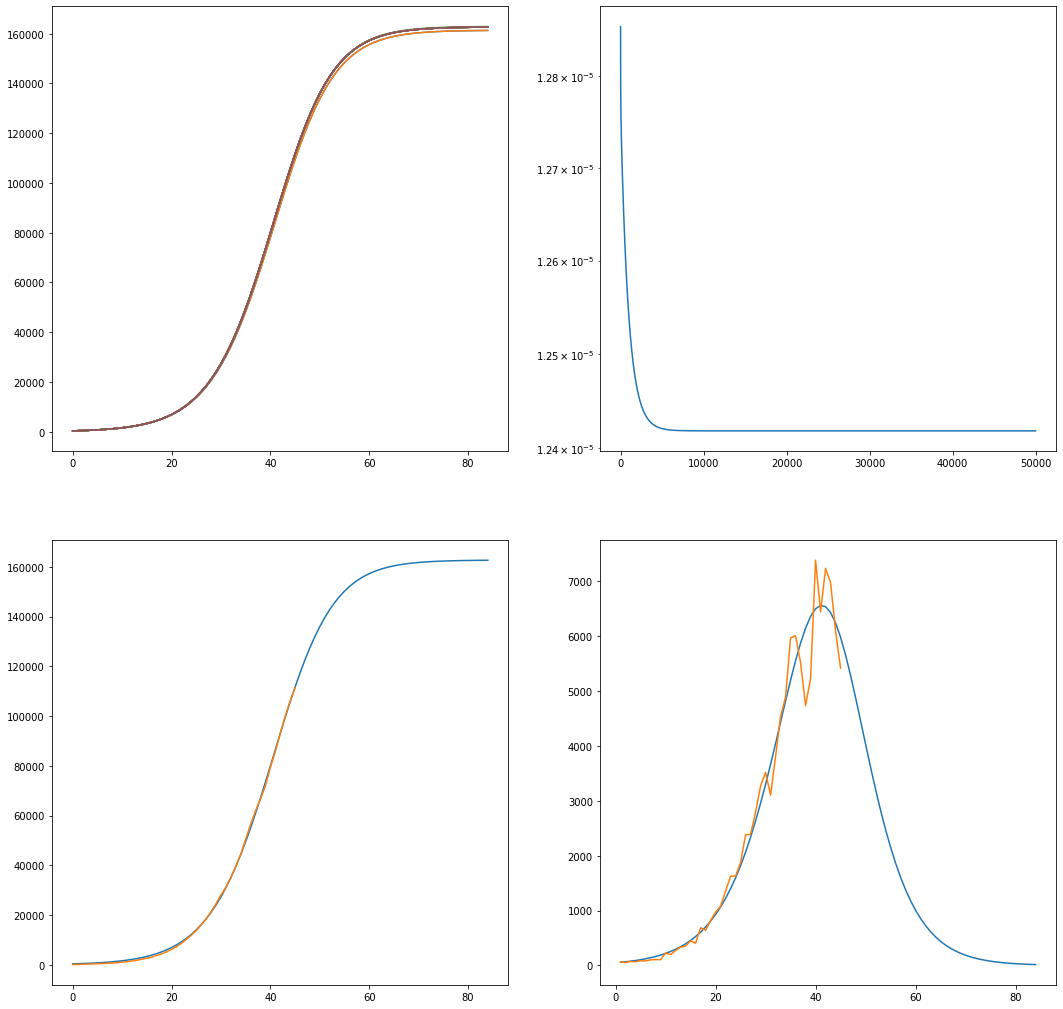

In [540]:
n_data = len(deaths)
R = np.float128(1.16)
scale = np.float128(1170000)
initial = np.float128(0.00031)


fig, ax = plt.subplots(2,2)  # Create a figure containing a single axes.
fig.set_size_inches(18, 18)
xs, ys = iter_params(R, initial)
ax[0,0].plot(xs, ys * scale)

errs = []
for n in range(50000):
    dydR, dyds, dydi, ys, err = calculate_gradient(R, scale, initial)
    errs.append(err)
    if n % 2000 == 0:
        ax[0,0].plot(xs, ys * scale)
        print(dydR, dyds, dydi)
    R -= dydR * np.float128(0.01)
    scale -= dyds * 10**13
    initial -= dydi * np.float128(0.000001)

highest = ys[-1] * scale
    
ax[1,0].plot(xs, ys * scale)
ax[1,0].plot(xs[:n_data], deaths)
ax[0,1].set_yscale('log')
ax[0,1].plot(errs[10:])
ax[1,1].plot(xs[1:], (ys[1:] - ys[:-1]) * scale)
ax[1,1].plot(xs[1:][:n_data-1], (deaths[1:] - deaths[:-1]))

pd.DataFrame(data={
    'highest': highest,
    'R': R,
    'scale': scale,
    'initial': initial,
    'err': err
}, index=[0])

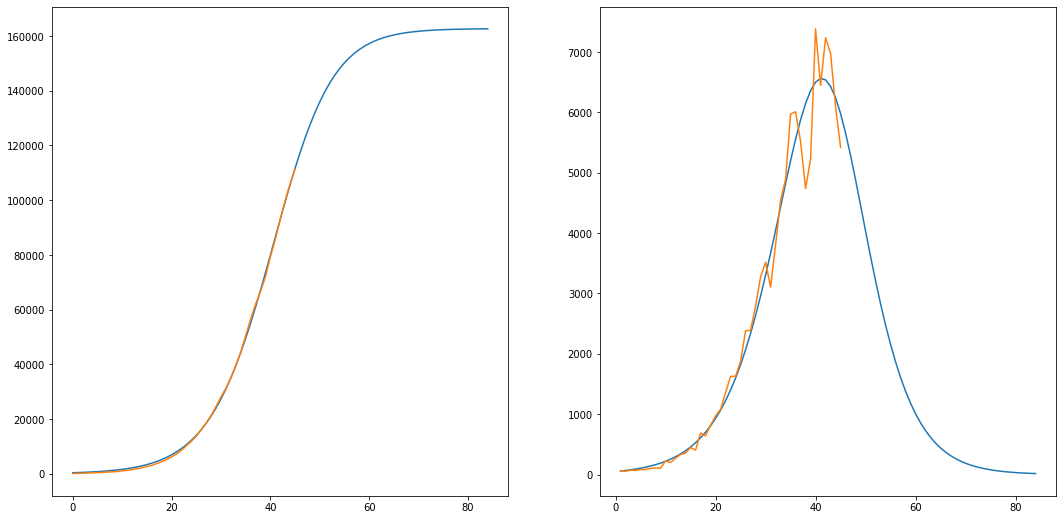

In [541]:
fig, ax = plt.subplots(1,2)  # Create a figure containing a single axes.
fig.set_size_inches(18, 9)
ax[0].plot(xs, ys * scale)
ax[0].plot(xs[:n_data], deaths)
ax[1].plot(xs[1:], (ys[1:] - ys[:-1]) * scale)
ax[1].plot(xs[1:][:n_data-1], (deaths[1:] - deaths[:-1]))

In [571]:
df = pd.DataFrame(
    {'deaths': (ys * scale).astype(int)},
    pd.date_range('2020-02-27', periods=85, freq='D'))
df['diff'] = df['deaths'] - df.shift(1)['deaths']
df[40:]

,deaths,diff
2020-04-07,79874,6499.0
2020-04-08,86433,6559.0
2020-04-09,92970,6537.0
2020-04-10,99398,6428.0
2020-04-11,105637,6239.0
2020-04-12,111615,5978.0
2020-04-13,117269,5654.0
2020-04-14,122553,5284.0
2020-04-15,127433,4880.0
2020-04-16,131891,4458.0
